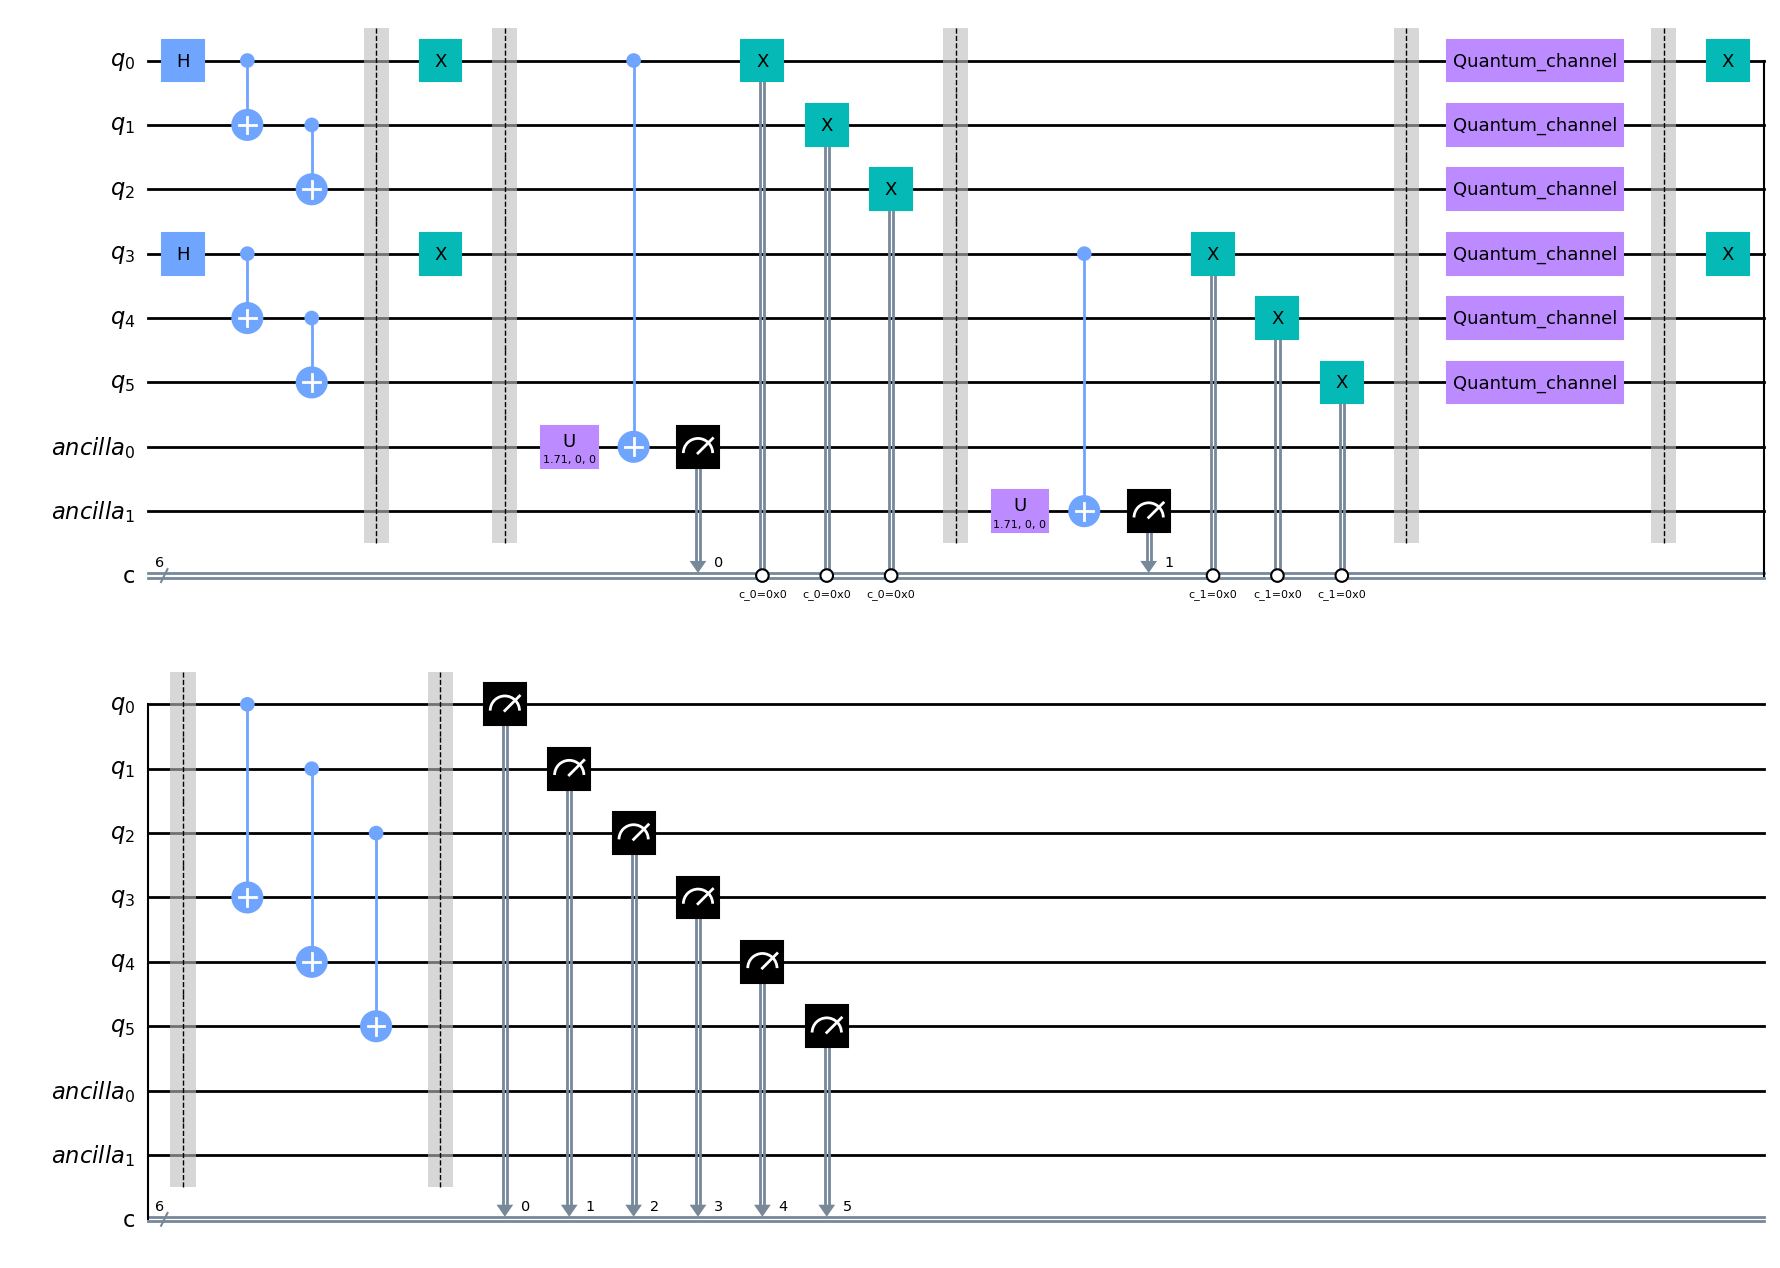

In [4]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, Aer,transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_city
from qiskit.providers.aer.noise import amplitude_damping_error, NoiseModel, depolarizing_error, ReadoutError
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

# Define the damping parameter for the amplitude damping channel
r = 0.25

### The circuit to creat a 3-qubit GHZ state
qcg = QuantumCircuit(3)
qcg.h([0])
qcg.cx([0], [1])
qcg.cx([1], [2])
GHZ_circ=qcg.to_gate(label="GHZ state")

##########

q = QuantumRegister(6, 'q')
anc = QuantumRegister(2, 'ancilla')
c = ClassicalRegister(6, 'c')
qc = QuantumCircuit(q, anc, c)

qc.h([0])
qc.cx([0], [1])
qc.cx([1], [2])


qc.h([3])
qc.cx([3], [4])
qc.cx([4], [5])

qc.barrier()
#changing structure of the density matrix
qc.x([0])
qc.x([3])
qc.barrier()

# Employing measurement on only one qubit (Ex: here third qubit of the GHZ state)
#theta = Parameter('θ')
theta=2*np.arctan(1/np.sqrt(1-r))
qc.u(theta,0,0,anc[0])
qc.cx(q[0], anc[0])
qc.measure(anc[0],0)
qc.x([0, 1, 2]).c_if(0, 0)# If M1 occured, apply Pauli-X gate on all qubits  
qc.barrier()
###### Second GHZ state
qc.u(theta,0,0,anc[1])
qc.cx(q[3], anc[1])
qc.measure(anc[1],1)
qc.x([3, 4, 5]).c_if(1, 0)# If M1 occured, apply Pauli-X gate on all qubits  

qc.barrier()
# Sending all qubits through amplitude damping channel to communication parties
error =amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)
qc.append(error, [0])
qc.append(error, [1])
qc.append(error, [2])
qc.append(error, [3])
qc.append(error, [4])
qc.append(error, [5])
qc.barrier()

#changing structure of the density matrix
qc.x(q[0])
qc.x(q[3])
qc.barrier()

#### Distillation
qc.cx(0, 3)
qc.cx(1, 4)
qc.cx(2, 5)
qc.barrier()

######################################

error_rate_eta=0
#Depolarizing error of CNOT gate:
error_rate_cnot =0# Adjust this value based on the desired error rate

# Create a depolarizing error for the CNOT gate
cnot_error = depolarizing_error(error_rate_cnot, 2)


# Create a noise model and add the CNOT error to it for the specified qubits
noise_model = NoiseModel()
noise_model = NoiseModel()
noise_model.add_quantum_error(cnot_error, 'cx', [0,1])
noise_model.add_quantum_error(cnot_error, 'cx', [1,2])
noise_model.add_quantum_error(cnot_error, 'cx', [3,4])
noise_model.add_quantum_error(cnot_error, 'cx', [4,5])
noise_model.add_quantum_error(cnot_error, 'cx', [0,6])
noise_model.add_quantum_error(cnot_error, 'cx', [3,7])
noise_model.add_quantum_error(cnot_error, 'cx', [0,3])
noise_model.add_quantum_error(cnot_error, 'cx', [1,4])
noise_model.add_quantum_error(cnot_error, 'cx', [2,5])
# Add custom readout error model to the existing noise model

eta= error_rate_eta# Adjust this value based on the desired readout error rate
error_meas_ancilla = ReadoutError([[1- eta, eta], [eta, 1- eta]])
noise_model.add_readout_error(error_meas_ancilla, [3]) 
noise_model.add_readout_error(error_meas_ancilla, [4]) 
noise_model.add_readout_error(error_meas_ancilla, [5]) 
noise_model.add_readout_error(error_meas_ancilla, [6])
noise_model.add_readout_error(error_meas_ancilla, [7])

####################################

qc.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
#qc.measure([3,4,5],[3,4,5])
qc.draw('mpl')

In [5]:
qc=qc.reverse_bits ()

Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method,noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'000000': 10342, '101000': 1134, '110011': 1137, '000100': 4565, '101101': 3504, '100011': 4524, '100001': 1580, '111111': 10276, '111011': 4619, '000111': 10294, '110000': 1131, '000110': 3443, '110001': 3444, '101011': 1183, '111001': 3428, '111000': 10368, '111010': 3413, '100100': 4663, '100010': 1499, '000101': 3421, '110010': 1498, '110110': 3453, '101010': 3531, '100000': 2003, '101001': 1547}


success: 24978 , fail: 75022 , total: 100000
Bell states counts: {'000000': 10342, '101000': 1134, '110000': 1131, '111000': 10368, '100000': 2003}
Bell new: {'000': 10342, '101': 1134, '110': 1131, '111': 10368, '100': 2003}
probability of success 0.24978
Fidelity= 0.8291293073780028


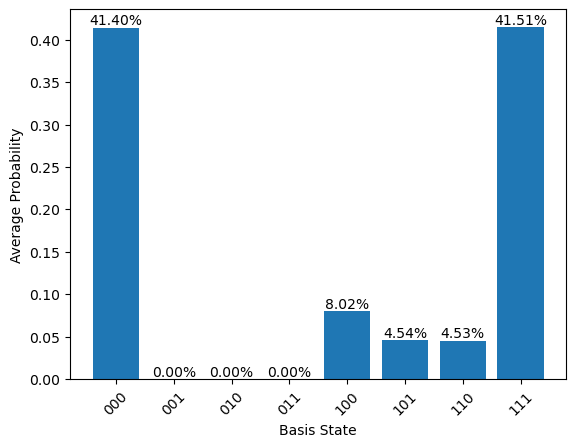

In [8]:
success, fail = 0, 0
Bell_states = {}
Bell_new = {}

for jj in counts:
    if (jj[3] ==jj[4]==jj[5]=='0'):#Consider the target entangled state in case of sacrificial qubit measurement result '1' ('0')
        success += counts[jj]
        Bell_state = jj
        if Bell_state in Bell_states:
            Bell_states[Bell_state] += counts[jj]
        else:
            Bell_states[Bell_state] = counts[jj]
    else:
        fail += counts[jj]

total = success + fail

# Extract the target qubits state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[:3]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]

print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
print('Bell states counts:', Bell_states)
print('Bell new:', Bell_new)
print('probability of success',success/(total))

# Convert counts to a sorted list of probabilities
basis_states = ['000', '001', '010', '011', '100', '101', '110', '111']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states]

prob_111 = probabilities[basis_states.index('111')]
prob_000 = probabilities[basis_states.index('000')]
fid=1/2*(prob_111+prob_000)+np.sqrt(prob_111*prob_000)
print('Fidelity=',fid)

# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
#plt.title(f'Average Probability of Basis States (r={r})')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
# Add percentage labels on top of each bar
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()
